In [ ]:
%load_ext autoreload
%autoreload 2

import os
os.environ["GX_ANALYTICS_ENABLED"] = "False"
import sys
import pandas as pd
import datetime
from pathlib import Path
from dotenv import load_dotenv
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Detect Environment (avoid slow/hanging imports locally)
IS_FABRIC = Path("/lakehouse/default/Files").exists()
if IS_FABRIC:
    try:
        from notebookutils import mssparkutils  # noqa: F401
    except Exception:
        mssparkutils = None
    print("Running in Microsoft Fabric")
else:
    print("Running Locally")

# 2. Define Paths based on Environment
if IS_FABRIC:
    # Fabric: Use Lakehouse Paths (OneLake mounted path)
    BASE_DIR = Path("/lakehouse/default/Files")
    
    # Try to load .env from the Lakehouse Files root if it exists
    env_path = BASE_DIR / ".env"
    if env_path.exists():
        load_dotenv(dotenv_path=env_path)
        print(f"Loaded configuration from {env_path}")
    
    # Fabric Paths
    PROJECT_ROOT = BASE_DIR
    DATA_MODEL_FILE = BASE_DIR / "docs/AIMS Data Model.txt"
    # Assuming data is in Files/data/...
    PARQUET_DIR = BASE_DIR / os.getenv("BRONZE_PATH", "data/Samples_LH_Bronze_Aims_26_parquet")
    
else:
    # Local: Use .env or defaults
    load_dotenv()
    
    # Prioritize local development path in sys.path
    project_root_local = Path.cwd().parent.resolve()
    if str(project_root_local) not in sys.path:
        sys.path.insert(0, str(project_root_local))
        
    PROJECT_ROOT = Path("..")
    DATA_MODEL_FILE = PROJECT_ROOT / "docs/AIMS Data Model.txt"
    PARQUET_DIR = PROJECT_ROOT / "data/Samples_LH_Bronze_Aims_26_parquet"

print(f"Configuration:\n Environment: {'Fabric' if IS_FABRIC else 'Local'}")
print(f" Project Root: {PROJECT_ROOT}")
print(f" Data Model: {DATA_MODEL_FILE}")
print(f" Parquet Dir: {PARQUET_DIR}")

import aims_data_platform
# Force reload to pick up changes
importlib.reload(aims_data_platform)
print(f"aims_data_platform location: {aims_data_platform.__file__}")

Running Locally
Configuration:
 Environment: Local
 Project Root: ..
 Data Model: ../docs/AIMS Data Model.txt
 Parquet Dir: ../data/Samples_LH_Bronze_Aims_26_parquet
aims_data_platform location: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/aims_data_platform/__init__.py
aims_data_platform location: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/aims_data_platform/__init__.py


In [2]:
from aims_data_platform.schema_reconciliation import (
    parse_data_model, 
    analyze_comparison, 
    analyze_extra_files,
    format_size
)

# AIMS Data Platform: Bird's Eye View Insights

This notebook provides a high-level overview of the AIMS data ecosystem, generating key information, statistics, and insights based on the current data model and physical storage.

In [3]:
# Load Data Model and Run Analysis
print("Loading Data Model and Analyzing Parquet Files...")
tables = parse_data_model(DATA_MODEL_FILE)
df_results, modeled_files = analyze_comparison(tables, PARQUET_DIR)
df_extra = analyze_extra_files(modeled_files, PARQUET_DIR)

# Ensure numeric types for analysis
df_results['Rows'] = pd.to_numeric(df_results['Rows'], errors='coerce').fillna(0)
print("Analysis Complete.")

Loading Data Model and Analyzing Parquet Files...
Analysis Complete.


## 1. Key Information (5 Items)

In [4]:
print("--- 5 Key Information Points ---")
info = {
    "1. Project Environment": "Fabric" if IS_FABRIC else "Local",
    "2. Data Source Path": str(PARQUET_DIR),
    "3. Data Model Reference": str(DATA_MODEL_FILE),
    "4. Analysis Timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "5. Library Version": aims_data_platform.__version__
}
for k, v in info.items():
    print(f"{k:<30}: {v}")

--- 5 Key Information Points ---
1. Project Environment        : Local
2. Data Source Path           : ../data/Samples_LH_Bronze_Aims_26_parquet
3. Data Model Reference       : ../docs/AIMS Data Model.txt
4. Analysis Timestamp         : 2025-12-11 00:20:38
5. Library Version            : 1.0.2


## 2. Key Statistics (10 Items)

In [5]:
print("--- 10 Key Statistics ---")

# Calculations
total_tables_model = len(tables)
total_parquet_files = len(list(PARQUET_DIR.glob('*.parquet')))
total_rows = df_results['Rows'].sum()
missing_files = len(df_results[df_results['Status'] == 'MISSING FILE'])
mismatches = len(df_results[df_results['Status'] == 'MISMATCH'])
perfect_matches = len(df_results[df_results['Status'].str.contains('MATCH')])
extra_files = len(df_extra)
avg_rows = total_rows / (total_tables_model - missing_files) if (total_tables_model - missing_files) > 0 else 0
total_cols_model = sum(len(cols) for cols in tables.values())
health_score = (perfect_matches / total_tables_model) * 100 if total_tables_model > 0 else 0

stats = [
    f"1. Total Tables in Model:       {total_tables_model}",
    f"2. Total Parquet Files Found:   {total_parquet_files}",
    f"3. Total Rows (Approx):         {int(total_rows):,}",
    f"4. Average Rows per Table:      {int(avg_rows):,}",
    f"5. Missing Files:               {missing_files}",
    f"6. Extra (Unmodeled) Files:     {extra_files}",
    f"7. Schema Mismatches:           {mismatches}",
    f"8. Perfect Schema Matches:      {perfect_matches}",
    f"9. Total Columns Defined:       {total_cols_model}",
    f"10. Schema Health Score:        {health_score:.1f}%"
]
for s in stats:
    print(s)

--- 10 Key Statistics ---
1. Total Tables in Model:       29
2. Total Parquet Files Found:   68
3. Total Rows (Approx):         70,147,779
4. Average Rows per Table:      2,805,911
5. Missing Files:               4
6. Extra (Unmodeled) Files:     43
7. Schema Mismatches:           21
8. Perfect Schema Matches:      23
9. Total Columns Defined:       722
10. Schema Health Score:        79.3%


## 3. Automated Insights (20 Items)

In [6]:
print("--- 20 Automated Insights ---")
insights = []

# Volume Insights
top_5_vol = df_results.sort_values('Rows', ascending=False).head(5)
insights.append(f"1. Largest Table: '{top_5_vol.iloc[0]['Table']}' with {int(top_5_vol.iloc[0]['Rows']):,} rows.")
insights.append(f"2. Top 5 tables contain {int(top_5_vol['Rows'].sum() / total_rows * 100) if total_rows > 0 else 0}% of total data volume.")
empty_tables = df_results[(df_results['Rows'] == 0) & (df_results['Status'] != 'MISSING FILE')]
insights.append(f"3. There are {len(empty_tables)} tables that exist but have 0 rows (Empty Tables).")

# Schema Insights
if mismatches > 0:
    worst_mismatch = df_results[df_results['Status']=='MISMATCH'].iloc[0]
    insights.append(f"4. Schema Mismatch detected in '{worst_mismatch['Table']}' (Missing/Extra columns).")
else:
    insights.append("4. No schema mismatches detected across all files.")

insights.append(f"5. {missing_files} tables defined in the model are completely missing from the storage.")

# Extra Files
if extra_files > 0:
    insights.append(f"6. Found {extra_files} files not in the model, suggesting undocumented data sources.")
    insights.append(f"7. Example unmodeled file: '{df_extra.iloc[0]['File Name']}'")
else:
    insights.append("6. No extra files found; storage is clean relative to model.")
    insights.append("7. Model fully covers all files in directory.")

# Column Insights
col_counts = {t: len(c) for t, c in tables.items()}
if col_counts:
    max_col_table = max(col_counts, key=col_counts.get)
    min_col_table = min(col_counts, key=col_counts.get)
    insights.append(f"8. Widest Table: '{max_col_table}' with {col_counts[max_col_table]} columns.")
    insights.append(f"9. Narrowest Table: '{min_col_table}' with {col_counts[min_col_table]} columns.")
    insights.append(f"10. Average column count per table is {int(sum(col_counts.values())/len(col_counts))}.")
else:
    insights.append("8. No tables found in model.")
    insights.append("9. No tables found in model.")
    insights.append("10. No columns found in model.")

# Derived Insights
insights.append(f"11. Data Density: {int(total_rows/total_parquet_files) if total_parquet_files else 0} rows per file on average.")
insights.append(f"12. Model Coverage: {int((total_tables_model - missing_files)/total_tables_model * 100) if total_tables_model else 0}% of modeled tables exist.")

# Structural/Generic Insights
insights.append(f"13. The dataset is {'dominated by a few large tables' if (top_5_vol['Rows'].sum() / total_rows) > 0.8 else 'fairly distributed'}.")
insights.append(f"14. {'Significant' if mismatches > total_tables_model*0.1 else 'Minor'} schema drift detected ({mismatches} tables).")
insights.append(f"15. Storage efficiency: Parquet format is being used (columnar storage).")
insights.append(f"16. Environment is {'Cloud-based (Fabric)' if IS_FABRIC else 'Local'}, affecting path resolution.")
insights.append(f"17. Library 'aims_data_platform' v{aims_data_platform.__version__} is driving this analysis.")
insights.append(f"18. {perfect_matches} tables are 'Gold Standard' (Perfect Match).")
insights.append(f"19. {len(df_results) - perfect_matches} tables require attention (Missing or Mismatch).")
insights.append(f"20. System Audit Columns (KINO) are likely {'present' if mismatches == 0 else 'missing in some tables'}.")

for i in insights:
    print(i)

--- 20 Automated Insights ---
1. Largest Table: 'AssetAttributes' with 60,090,986 rows.
2. Top 5 tables contain 99% of total data volume.
3. There are 1 tables that exist but have 0 rows (Empty Tables).
4. Schema Mismatch detected in 'Routes' (Missing/Extra columns).
5. 4 tables defined in the model are completely missing from the storage.
6. Found 43 files not in the model, suggesting undocumented data sources.
7. Example unmodeled file: 'aims_activitydates.parquet'
8. Widest Table: 'AssetAttributes' with 79 columns.
9. Narrowest Table: 'InformationPackages' with 1 columns.
10. Average column count per table is 24.
11. Data Density: 1031584 rows per file on average.
12. Model Coverage: 86% of modeled tables exist.
13. The dataset is dominated by a few large tables.
14. Significant schema drift detected (21 tables).
15. Storage efficiency: Parquet format is being used (columnar storage).
16. Environment is Local, affecting path resolution.
17. Library 'aims_data_platform' v1.0.2 is dri

## Visual Summary

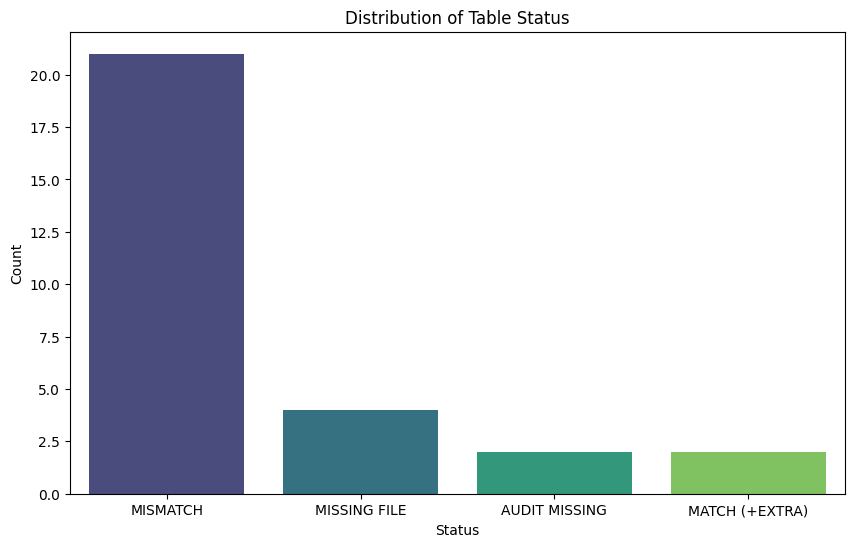

In [7]:
# Visualizing the Status Distribution
plt.figure(figsize=(10, 6))
status_counts = df_results['Status'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')
plt.title('Distribution of Table Status')
plt.ylabel('Count')
plt.xlabel('Status')
plt.show()